In [423]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import plotly.express as px
df = pd.read_csv('LEAD.csv', sep=';',encoding='utf-8',engine='python',quoting=3,on_bad_lines='skip',parse_dates=['"Дата создания"', '"Дата изменения"'])
df.rename(columns={'"Дата создания"': 'created_at', '"Дата изменения"': 'closed_at'}, inplace=True)

df['created_at'] = df['created_at'].astype(str).str.strip().str.replace('"', '', regex=False)
df['closed_at'] = df['closed_at'].astype(str).str.strip().str.replace('"', '', regex=False)

df['created_at'] = pd.to_datetime(df['created_at'], format="%d.%m.%Y %H:%M:%S", errors='coerce')
df['closed_at'] = pd.to_datetime(df['closed_at'], format="%d.%m.%Y %H:%M:%S", errors='coerce')

display(df[['created_at', 'closed_at']].head(20).style.set_caption("Даты создания и закрытия лидов"))



/var/folders/jj/_83b2y215bv5_bt2j4m4jvl00000gp/T/ipykernel_3516/2778931307.py:15: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/jj/_83b2y215bv5_bt2j4m4jvl00000gp/T/ipykernel_3516/2778931307.py:15: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,created_at,closed_at
0,2025-06-23 10:28:56,2025-06-23 10:28:56
1,NaT,NaT
2,2025-06-23 07:42:57,2025-06-23 07:42:57
3,2025-06-21 11:06:29,2025-06-21 11:06:37
4,2025-06-21 11:04:02,2025-06-21 11:04:10
5,2025-06-21 11:01:26,2025-06-21 11:01:34
6,2025-06-21 10:59:48,2025-06-21 10:59:56
7,2025-06-21 10:57:21,2025-06-21 10:57:31
8,2025-06-21 10:53:53,2025-06-21 10:54:00
9,2025-06-21 10:52:14,2025-06-21 10:52:22


In [425]:
df_day = leads_per_day.reset_index()
df_day.columns = ['Дата', 'Количество лидов']

df_week = leads_per_week.reset_index()
df_week.columns = ['Неделя', 'Количество лидов']

display(df_day.tail().style.set_caption("📅 Лиды по дням"))
display(df_week.tail().style.set_caption("🗓️ Лиды по неделям"))

,Дата,Количество лидов
1400,2025-06-18,4
1401,2025-06-19,5
1402,2025-06-20,7
1403,2025-06-21,8
1404,2025-06-23,2


,Неделя,Количество лидов
277,2025-05-26/2025-06-01,33
278,2025-06-02/2025-06-08,19
279,2025-06-09/2025-06-15,33
280,2025-06-16/2025-06-22,40
281,2025-06-23/2025-06-29,2


Series([], Name: count, dtype: int64)
status_clean
Неуспешно     16814
В процессе     1587
Пусто           836
Входящее          5
Name: count, dtype: int64


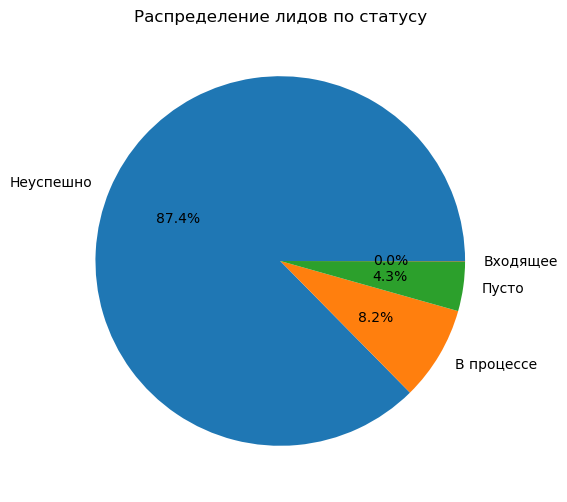

In [427]:
df.rename(columns={'"Стадия"': 'status'}, inplace=True)
valid_statuses = [
    "Нецелевая заявка",
    "Передано в работу",
    "Входящее обращение"
]

df_clean = df[df['status'].isin(valid_statuses)]

print(df_clean['status'].value_counts())


def categorize_status(s):
    if pd.isna(s):
        return "Пусто"
    s = str(s).strip().strip('"')
    if s == "Нецелевая заявка":
        return "Неуспешно"
    elif s == "Передано в работу":
        return "В процессе"
    elif s == "Входящее обращение":
        return "Входящее"
df['status_clean'] = df['status'].apply(categorize_status)
print(df['status_clean'].value_counts())

df['status_clean'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(6, 6),
    ylabel='',
    title='Распределение лидов по статусу'
)
plt.show()


In [429]:
df_valid = df_valid.copy()
df_valid['duration_hours'] = (df_valid['closed_at'] - df_valid['created_at']).dt.total_seconds() / 3600

avg_hours = df_valid['duration_hours'].mean()
avg_days = avg_hours / 24

print(f"Среднее время от создания до закрытия:{avg_days:.1f} дней")


Среднее время от создания до закрытия:167.9 дней


#### unprocessed = df[df['closed_at'].isna()]
print(f" Лидов без обработки: {len(unprocessed)} из {len(df)} ({len(unprocessed)/len(df)*100:.1f}%)")


In [433]:
now = pd.Timestamp.now()

stale_leads = df[(df['closed_at'].isna()) & (df['created_at'] < now - timedelta(days=3))]

print(f"Залежалых лидов (старше 3 дней без закрытия): {len(stale_leads)}")


Залежалых лидов (старше 3 дней без закрытия): 2


In [435]:
in_work = df[df['status_clean'] == "В процессе"].dropna(subset=['closed_at', 'created_at']).copy()

in_work['time_to_accept_hr'] = (in_work['closed_at'] - in_work['created_at']).dt.total_seconds() / 3600
print("Среднее время принятия в работу:", round(in_work['time_to_accept_hr'].mean(), 1), "часов")


Среднее время принятия в работу: 16115.9 часов


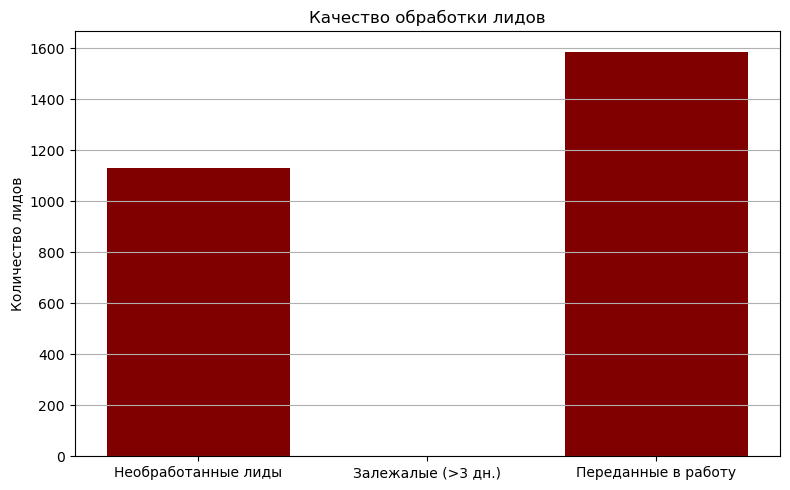

In [437]:
metrics = {
    "Необработанные лиды": len(unprocessed),
    "Залежалые (>3 дн.)": len(stale_leads),
    "Переданные в работу": len(in_work),
}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='maroon')
plt.title('Качество обработки лидов')
plt.ylabel('Количество лидов')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

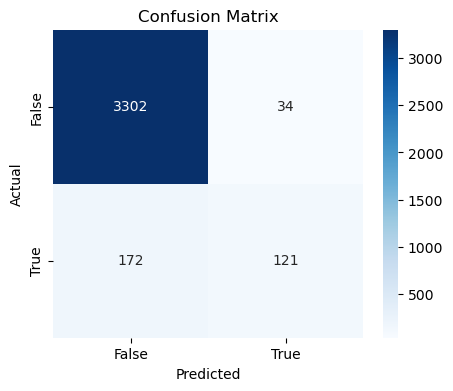

In [439]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


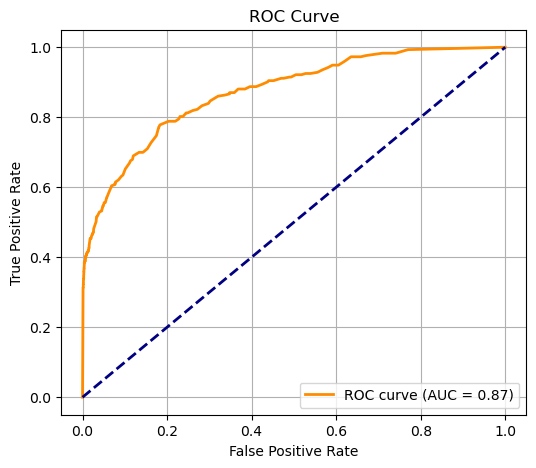

In [440]:
y_proba = model.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


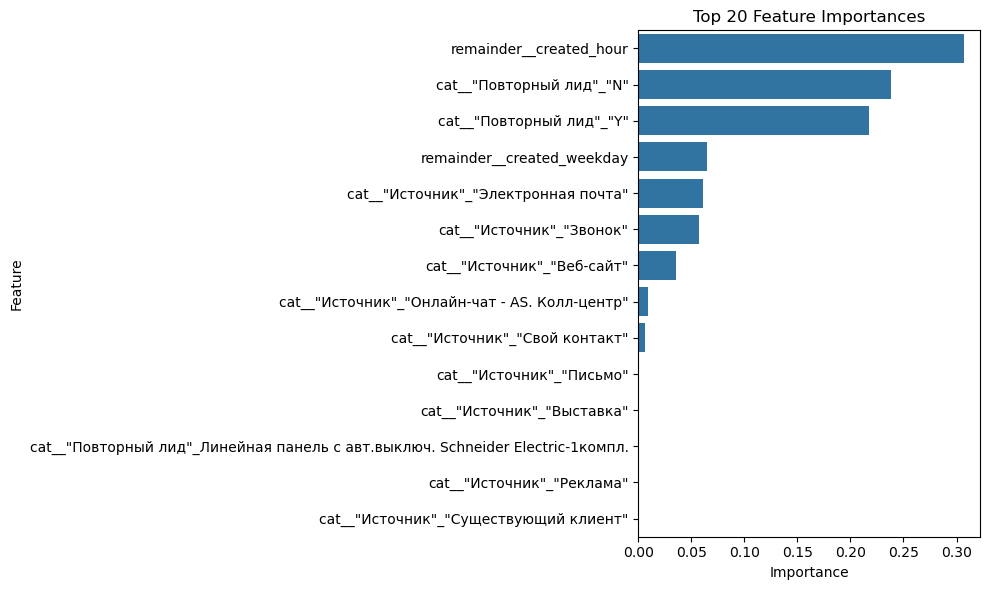

In [443]:
feature_names = model.named_steps['prep'].get_feature_names_out()
importances = model.named_steps['clf'].feature_importances_

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df, x='Importance', y='Feature')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [444]:
df['is_success'] = df['status'].str.strip('"') == 'Передано в работу'

df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_hour'] = df['created_at'].dt.hour
df['created_weekday'] = df['created_at'].dt.weekday

features = ['"Источник"', '"Повторный лид"', 'created_hour', 'created_weekday']
df_model = df[features + ['is_success']].dropna()

X = df_model[features]
y = df_model['is_success']

categorical = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')



              precision    recall  f1-score   support

       False       0.95      0.99      0.97      3336
        True       0.80      0.41      0.54       293

    accuracy                           0.94      3629
   macro avg       0.88      0.70      0.75      3629
weighted avg       0.94      0.94      0.94      3629



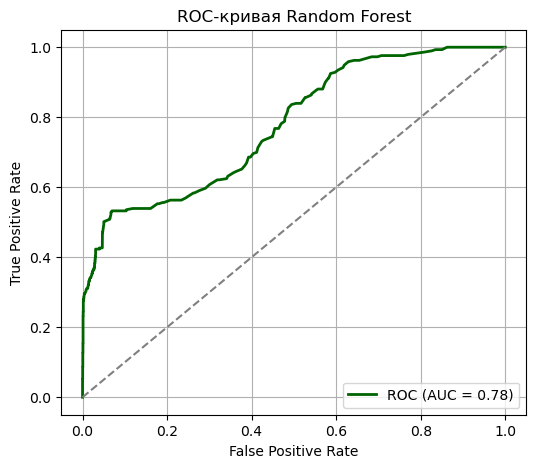

In [456]:
model = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

       False       0.94      0.98      0.96      3336
        True       0.65      0.33      0.44       293

    accuracy                           0.93      3629
   macro avg       0.80      0.66      0.70      3629
weighted avg       0.92      0.93      0.92      3629



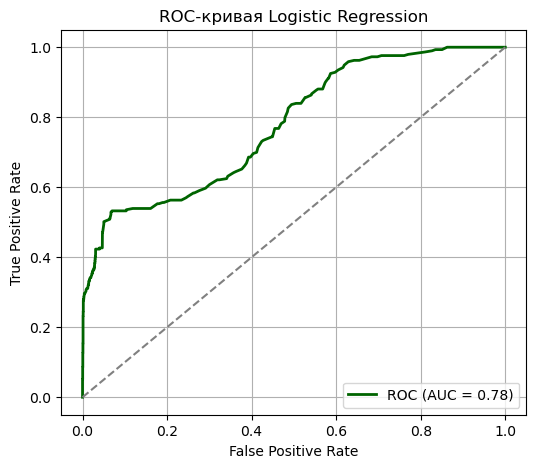

In [454]:
log_model = Pipeline([
    ('prep', preprocessor), 
    ('clf', LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
print(classification_report(y_test, y_pred_log))

fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


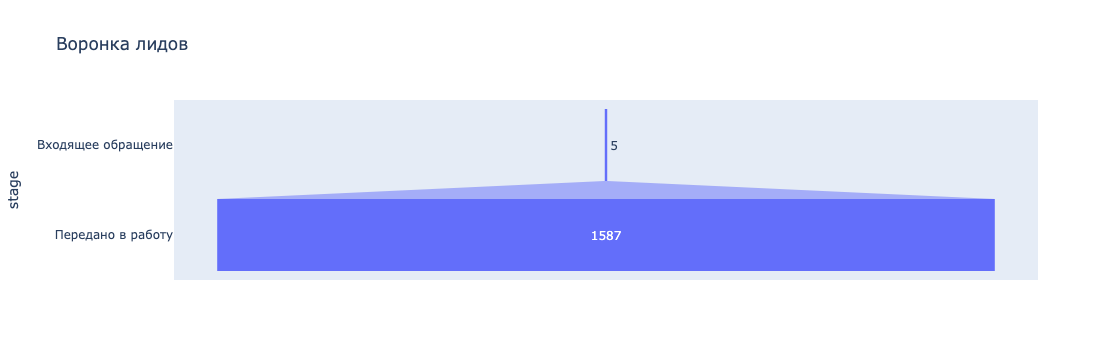

In [449]:
stage_mapping = {
    'Входящее': 'Входящее обращение',
    'Уточнение': 'Уточнение информации',
    'В процессе': 'Передано в работу',
    'Нецелевая заявка': 'Нецелевая заявка',
    'Не удалось связаться': 'Не удается связаться'
}

df['stage'] = df['status_clean'].map(stage_mapping)

df_funnel = df[df['stage'].notnull()]

funnel_data = df_funnel['stage'].value_counts().reindex([
    'Входящее обращение',
    'Уточнение информации',
    'Передано в работу',
    'Нецелевая заявка',
    'Не удается связаться'
]).dropna().reset_index()

funnel_data.columns = ['stage', 'count']

funnel_data['count'] = funnel_data['count'].astype(int)


fig = px.funnel(funnel_data, x='count', y='stage', title='Воронка лидов')
fig.show()
